In [1]:
import dataset_utils
import pandas as pd
from torchvision import transforms
import torch
import torchvision
from dataset_utils import *
import numpy as np
import matplotlib.pyplot as plt
csv_path = 'final_dataset.csv'
image_path = 'image_dataset/'
batch_size = 16
shuffle_loaders = False

In [31]:
df = pd.read_csv(csv_path,index_col=0)
imsize = 64
tform = transforms.Compose([transforms.Resize((imsize,imsize)),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder(image_path, transform=tform)

img2dna = get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(one_hot_encoding)
random.seed(42)
X_train_val, X_test, y_train_val, y_test = data_split(nucleotides,0.2,random_state=42,)
train_data = X_train_val
train_data['species_name'] = y_train_val
X_train, X_validation, y_train, y_validation = data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = image_splits_from_df(X_train,X_validation,X_test,image_dataset)
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets            
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
train_val_imgs = torch.utils.data.Subset(whole_dataset, train_indices+val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=shuffle_loaders, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=shuffle_loaders, num_workers=2)
train_val_loader = torch.utils.data.DataLoader(train_val_imgs, batch_size=batch_size,shuffle=shuffle_loaders, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=batch_size,shuffle=shuffle_loaders, num_workers=2)
dataloaders = {"train":train_loader,"val":val_loader,"test":test_loader,'train_val':train_val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices),'test':len(test_imgs.indices),'train_val':len(train_val_imgs.indices)}



In [32]:
all_species_labels = list(range(n_classes))
described_species_labels_train = set(np.array([image_dataset.targets[i] for i in train_indices]))
described_species_labels_trainval = set(np.array([image_dataset.targets[i] for i in train_indices+val_indices]))

In [33]:
n_seen_val = 0
for i in val_indices:
    if image_dataset[i][1] in described_species_labels_train:
        n_seen_val+=1
        

In [34]:
n_seen_test = 0
for i in test_indices:
    if image_dataset[i][1] in described_species_labels_trainval:
        n_seen_test+=1
        

In [35]:
print(f"Number of seen training samples:{len(train_indices)}")
print(f"Number of seen val samples:{n_seen_val}")
print(f"Number of unseen val samples:{len(val_indices)-n_seen_val}")
print(f"Number of seen test samples:{n_seen_test}")
print(f"Number of unseen test samples:{len(test_indices)-n_seen_test}")

Number of seen training samples:13039
Number of seen val samples:3234
Number of unseen val samples:3721
Number of seen test samples:4990
Number of unseen test samples:7440


In [36]:
barplotlabels = ["train","val seen","val unseen","test seen","test unseen"]

Text(0.5, 1.0, 'Nostro dataset')

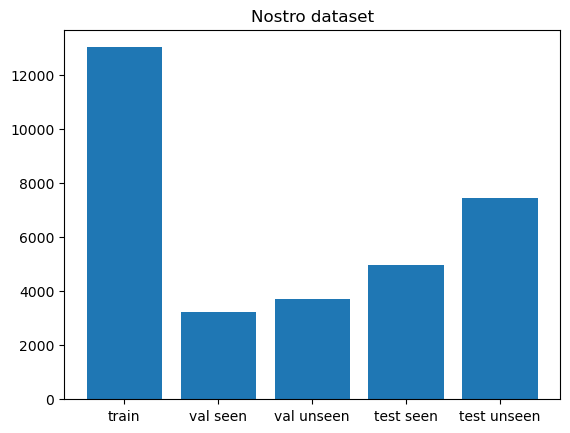

In [37]:
plt.bar(barplotlabels,[len(train_indices),n_seen_val,len(val_indices)-n_seen_val,n_seen_test,len(test_indices)-n_seen_test])
plt.title("Nostro dataset")

In [38]:
from scipy.io import loadmat
paper_data = loadmat('data/INSECTS/data.mat')
paper_splits = loadmat('data/INSECTS/splits.mat')

train_indices = paper_splits['train_loc']-1
image_train_features = torch.tensor(paper_data['embeddings_img'][train_indices]).squeeze()
expanded_train_dna_features = torch.tensor(paper_data['embeddings_dna'][train_indices]).squeeze()
image_train_labels= torch.tensor(paper_data['labels'][train_indices],dtype=int).squeeze()-1
expanded_train_dna_labels= torch.tensor(paper_data['labels'][train_indices],dtype=int).squeeze()-1

val_indices = np.concatenate((paper_splits['val_seen_loc'],paper_splits['val_unseen_loc']),axis=1)-1
image_val_features = torch.tensor(paper_data['embeddings_img'][val_indices]).squeeze()
expanded_val_dna_features = torch.tensor(paper_data['embeddings_dna'][val_indices]).squeeze()
image_val_labels= torch.tensor(paper_data['labels'][val_indices],dtype=int).squeeze()-1
expanded_val_dna_labels= torch.tensor(paper_data['labels'][val_indices],dtype=int).squeeze()-1


test_indices = np.concatenate((paper_splits['test_seen_loc'],paper_splits['test_unseen_loc']),axis=1)-1
image_test_features = torch.tensor(paper_data['embeddings_img'][test_indices]).squeeze()
expanded_test_dna_features = torch.tensor(paper_data['embeddings_dna'][test_indices]).squeeze()
image_test_labels= torch.tensor(paper_data['labels'][test_indices],dtype=int).squeeze()-1
expanded_test_dna_labels= torch.tensor(paper_data['labels'][test_indices],dtype=int).squeeze()-1
species2genus = paper_data['G'].astype(int) #np.vstack([-1,paper_data['G'].astype(int)])
species2genus = species2genus - min(species2genus)
described_species_labels = image_train_labels.unique().numpy()

Text(0.5, 1.0, 'Dataset del paper')

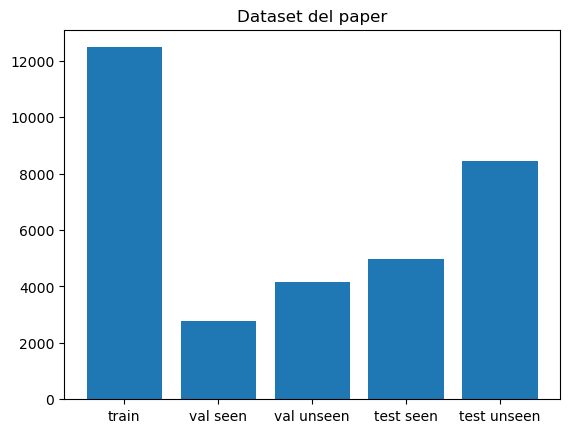

In [39]:
plt.bar(barplotlabels,[len(train_indices[0]),
                       len(paper_splits['val_seen_loc'][0]),
                       len(paper_splits['val_unseen_loc'][0]),
                       len(paper_splits['test_seen_loc'][0]),
                       len(paper_splits['test_unseen_loc'][0]),]
                       )
plt.title("Dataset del paper")


In [40]:
len(paper_splits['val_seen_loc'][0])

2786